In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm as tqdm


In [17]:
# === PART 1 OF Q3.1 ===

# Load preprocessed datasets
df_a = pd.read_parquet('ml_ready_data/set-a-scaled.parquet')
df_b = pd.read_parquet('ml_ready_data/set-b-scaled.parquet')
print(df_a.shape)
print(df_a.isna().any().any(), ", giaa")    #checks if there is some NaN value in dataframe
df_a.isna().sum().sum()    #returns count of NaN values
df_a.isna().sum()          #returns count of NaN values, per each column
df_c = pd.read_parquet('ml_ready_data/set-c-scaled.parquet')  # Test set

(196000, 45)
False , giaa


In [18]:
print(df_a.shape)
static_vars = ['Age', 'Gender', 'Height', 'Weight']
time_series_vars = [col for col in df_a.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]

patient_id = df_a['PatientID'][0]  # Example PatientID

# Select rows corresponding to the specific PatientID
patient_data = df_a[df_a['PatientID'] == patient_id]
print(patient_data.shape)

(196000, 45)
(49, 45)


In [19]:
time_series_data = patient_data[time_series_vars]
print(time_series_data.shape)
#print(time_series_data)

(49, 37)


# InfoNCE loss handling multiple negatives using batch matrix multiplication (bmm)

In [20]:
import torch
import torch.nn.functional as F

def info_nce_loss(anchor, positive, negatives, temperature=0.1):
    """
    Computes the InfoNCE loss for contrastive learning.

    Args:
    - anchor: Tensor of shape (batch_size, embedding_dim)
    - positive: Tensor of shape (batch_size, embedding_dim)
    - negatives: Tensor of shape (batch_size, num_negatives, embedding_dim)
    - temperature: Temperature scaling parameter

    Returns:
    - loss: Scalar tensor representing the InfoNCE loss
    """

    # Compute cosine similarity between anchor and positive (shape: batch_size,)
    positive_similarity = F.cosine_similarity(anchor, positive, dim=-1)

    # Compute cosine similarity between anchor and each negative sample
    negatives = negatives.view(anchor.shape[0], -1, anchor.shape[1])  # Ensure correct shape
    negative_similarity = torch.bmm(negatives, anchor.unsqueeze(-1)).squeeze(-1)  # Shape: (batch_size, num_negatives)

    # Apply temperature scaling
    positive_similarity = positive_similarity / temperature
    negative_similarity = negative_similarity / temperature

    # Stack positive similarity and negative similarities together
    logits = torch.cat([positive_similarity.unsqueeze(1), negative_similarity], dim=1)  # (batch_size, 1 + num_negatives)

    # Labels: first column corresponds to the positive pair
    labels = torch.zeros(logits.size(0), dtype=torch.long, device=anchor.device)

    # Compute cross-entropy loss
    loss = F.cross_entropy(logits, labels)
    
    return loss


In [8]:
import torch
import torch.nn.functional as F

def info_nce_loss(anchor, positive, negatives, temperature=0.1):
    # Compute cosine similarity between anchor and positive
    positive_similarity = F.cosine_similarity(anchor, positive, dim=-1)  # Shape: (batch_size,)
    
    # Compute cosine similarity between anchor and all negative samples
    negative_similarity = torch.matmul(anchor, negatives.T)  # Shape: (batch_size, num_negatives)
    
    # Apply temperature scaling
    positive_similarity /= temperature
    negative_similarity /= temperature
    
    # Concatenate positive similarity and negative similarity
    logits = torch.cat([positive_similarity.unsqueeze(1), negative_similarity], dim=1)  # Shape: (batch_size, 1 + num_negatives)
    
    # Labels: the first column (positive similarity) is the correct class (0 index)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(anchor.device)
    
    # Cross-entropy loss between logits and labels
    loss = F.cross_entropy(logits, labels)
    return loss


# Create Anchor, 1x Positive, multiple Negatives

In [21]:
import numpy as np
import random

def create_positive_negative_pairs(df, time_series_vars, seq_length=48, window_size=12, num_negatives=2):
    """
    Create positive and multiple negative pairs from time-series data for contrastive learning.
    
    Args:
    - df: The dataframe containing the time-series data for all patients.
    - time_series_vars: List of time-series variable names (37 time-series variables).
    - seq_length: Length of the time-series sequence (e.g., 48 hours).
    - window_size: Length of each time-series window (e.g., 12 hours).
    - num_negatives: Number of negative samples per positive pair.
    
    Returns:
    - positive_pairs: List of tuples (xref, xpos) for positive pairs.
    - negative_pairs: List of tuples (xref, [xneg1, xneg2, ..., xnegN]) for negative pairs.
    """
    positive_pairs = []
    negative_pairs = []
    
    grouped = df.groupby('PatientID')
    patient_ids = df['PatientID'].unique()

    # Iterate over each patient
    for patient_id, patient_data in grouped:
        time_series_data = patient_data[time_series_vars].values
        
        if len(time_series_data) < seq_length:
            continue
        
        for i in range(0, seq_length - window_size, window_size):  
            xpos = time_series_data[i:i+window_size]  
            xref = time_series_data[i+window_size:i+2*window_size]  

            if xref.shape[0] == window_size:
                positive_pairs.append((xref, xpos))
                
                # Select multiple negatives from different patients
                negative_samples = []
                sampled_patient_ids = random.sample([pid for pid in patient_ids if pid != patient_id], num_negatives)

                for other_patient_id in sampled_patient_ids:
                    other_patient_data = df[df['PatientID'] == other_patient_id][time_series_vars].values
                    if len(other_patient_data) >= seq_length:
                        xneg = other_patient_data[:window_size]  
                        negative_samples.append(xneg)

                if len(negative_samples) == num_negatives:
                    negative_pairs.append((xref, np.array(negative_samples)))  # Shape: (xref, num_negatives, window_size, features)

    min_len = min(len(positive_pairs), len(negative_pairs))
    positive_pairs = positive_pairs[:min_len]
    negative_pairs = negative_pairs[:min_len]

    return positive_pairs, negative_pairs

# Example usage:
positive_pairs, negative_pairs = create_positive_negative_pairs(df_a, time_series_vars, num_negatives=5)

# Print a sample positive and negative pair
print(f"Sample Positive Pair: {positive_pairs[0]}")
print(f"Sample Negative Pair Shape: {negative_pairs[0][1].shape}")  # Should print (num_negatives, window_size, num_features)


Sample Positive Pair: (array([[-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.2173913 ,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -1.30769231,
        -1.15003751, -0.80952381, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.18181818,
        -0.03571429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -7.        ,  0.        ],
       [-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.13043478,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -0.76923077,
        -0.69992498, -0.61904762, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.09090909,
        -0.03571429,  0.        ,  0.        ,  0.        ,  0.   

In [7]:

# Convert lists to NumPy arrays for easier saving
positive_pairs_np = np.array(positive_pairs, dtype=object)  # dtype=object to handle tuples
negative_pairs_np = np.array(negative_pairs, dtype=object)

# Save to disk
np.save("positive_pairs.npy", positive_pairs_np)
np.save("negative_pairs.npy", negative_pairs_np)

print("Embeddings saved successfully!")


Embeddings saved successfully!


In [9]:
import numpy as np

positive_pairs = np.load("positive_pairs.npy", allow_pickle=True)
negative_pairs = np.load("negative_pairs.npy", allow_pickle=True)



# Create Anchor, 1x Positive, 1x Negatives

In [11]:
import numpy as np
import random

def create_positive_negative_pairs(df, time_series_vars, seq_length=48, window_size=12):
    """
    Create positive and negative pairs from time-series data for contrastive learning.
    
    Args:
    - df_a: The dataframe containing the time-series data for all patients.
    - time_series_vars: List of time-series variable names (37 time-series variables).
    - seq_length: Length of the time-series sequence (e.g., 48 hours).
    - window_size: Length of each time-series window (e.g., 12 hours).
    
    Returns:
    - positive_pairs: List of tuples (xref, xpos) for positive pairs.
    - negative_pairs: List of tuples (xref, xneg) for negative pairs.
    """
    positive_pairs = []
    negative_pairs = []
    
    # Group the data by PatientID
    grouped = df.groupby('PatientID')

    # Iterate over each patient
    for patient_id, patient_data in grouped:
        # Extract the time-series data for the current patient
        time_series_data = patient_data[time_series_vars].values
        
        # Ensure the time-series data is long enough
        if len(time_series_data) < seq_length:
            continue  # Skip patients with insufficient data
        
        # Create positive pairs by slicing the sequence correctly
        for i in range(0, seq_length - window_size, window_size):  # Ensure valid slicing
            xpos = time_series_data[i:i+window_size]  # First time window (positive)
            xref = time_series_data[i+window_size:i+2*window_size]  # Next time window (positive)
            
            # Ensure xref is valid (i+2*window_size must be within bounds)
            if xref.shape[0] == window_size:
                positive_pairs.append((xref, xpos))
            
            # Negative pair: randomly pick a full time-series sequence from another patient
            other_patient_id = random.choice([pid for pid in df['PatientID'].unique() if pid != patient_id])
            other_patient_data = df[df['PatientID'] == other_patient_id][time_series_vars].values
            
            # Ensure other patient's sequence is long enough
            if len(other_patient_data) >= seq_length:
                xneg = other_patient_data[:window_size]  # Take the first 12 steps from another patient
                negative_pairs.append((xref, xneg))
    
    # Ensure that the number of positive and negative pairs are the same
    min_len = min(len(positive_pairs), len(negative_pairs))
    positive_pairs = positive_pairs[:min_len]
    negative_pairs = negative_pairs[:min_len]
    
    return positive_pairs, negative_pairs


# Example usage:
positive_pairs, negative_pairs = create_positive_negative_pairs(df_a, time_series_vars)

# Print a sample positive and negative pair
print(f"Sample Positive Pair: {positive_pairs[0]}")
print(f"Sample Negative Pair: {negative_pairs[0]}")


Sample Positive Pair: (array([[-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.2173913 ,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -1.30769231,
        -1.15003751, -0.80952381, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.18181818,
        -0.03571429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -7.        ,  0.        ],
       [-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.13043478,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -0.76923077,
        -0.69992498, -0.61904762, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.09090909,
        -0.03571429,  0.        ,  0.        ,  0.        ,  0.   

In [22]:
print(positive_pairs[0][0].shape) #print shape of first positive pair, namely the reference time series window
print(positive_pairs[0][1].shape) #" of the second positive pair, another time window of the same patient
print(len(positive_pairs) == len(negative_pairs))
print(len(positive_pairs))
print(negative_pairs[0][0].shape)
print(negative_pairs[0][1].shape)

print(positive_pairs[1][0].shape)

(12, 37)
(12, 37)
True
12000
(12, 37)
(5, 12, 37)
(12, 37)


# DataLoader with multiple Negatives

In [23]:
import torch

class ContrastiveLearningDataset(torch.utils.data.Dataset):
    def __init__(self, positive_pairs, negative_pairs):
        self.positive_pairs = positive_pairs  # List of (xref, xpos)
        self.negative_pairs = negative_pairs  # List of (xref, [xneg1, xneg2, ...])

    def __len__(self):
        assert len(self.positive_pairs) == len(self.negative_pairs), "Mismatch in positive and negative pairs length"
        return len(self.positive_pairs)

    def __getitem__(self, idx):
        # Positive pair
        xref_pos, xpos = self.positive_pairs[idx]  # (xref, xpos)
        
        # Negative samples (multiple)
        xref_neg, xneg_list = self.negative_pairs[idx]  # (xref, [xneg1, xneg2, ...])
        
        # Convert to tensors
        xref_pos = torch.tensor(xref_pos, dtype=torch.float32)  # Anchor
        xpos = torch.tensor(xpos, dtype=torch.float32)  # Positive sample
        xref_neg = torch.tensor(xref_neg, dtype=torch.float32)  # Anchor again (for consistency)
        
        # Convert the list of negatives to a tensor (Shape: num_negatives × window_size × features)
        xneg = torch.tensor(xneg_list, dtype=torch.float32)  # Multiple negative samples
        
        return xref_pos, xpos, xref_neg, xneg  # Return multiple negatives


# DataLoader with a single Negative pair per each anchor

In [17]:
class ContrastiveLearningDataset(torch.utils.data.Dataset):
    def __init__(self, positive_pairs, negative_pairs):
        self.positive_pairs = positive_pairs
        self.negative_pairs = negative_pairs

    def __len__(self):
        # Ensure both pairs have the same length
        assert len(self.positive_pairs) == len(self.negative_pairs), "Positive and negative pairs must have the same length"
        return len(self.positive_pairs)

    def __getitem__(self, idx):
        # Ensure idx is within bounds
        if idx >= len(self.positive_pairs) or idx >= len(self.negative_pairs):
            raise IndexError("Index is out of range")
        
        xref_pos, xpos = self.positive_pairs[idx]  # Positive pair
        xref_neg, xneg = self.negative_pairs[idx]  # Negative pair

        # Convert them to tensors
        xref_pos = torch.tensor(xref_pos, dtype=torch.float32)
        xpos = torch.tensor(xpos, dtype=torch.float32)
        xref_neg = torch.tensor(xref_neg, dtype=torch.float32)
        xneg = torch.tensor(xneg, dtype=torch.float32)
        
        return xref_pos, xpos, xref_neg, xneg


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, embedding_size)
    
    def forward(self, x):
        # Ensure input is 3D: (batch_size, seq_length=1, input_size)
        if x.dim() == 2:  
            x = x.unsqueeze(1)  # Add sequence dimension (batch_size, 1, input_size)

        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the LAST TIME STEP from lstm_out instead of h_n[-1]
        last_hidden = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        embedding = self.fc(last_hidden)  # Shape: (batch_size, embedding_size)
        
        return embedding

# Define model hyperparameters
input_size = 37  # Number of time-series features
hidden_size = 16  # LSTM hidden state size
embedding_size = 32  # Size of the embedding vector

# Initialize the model
model = LSTMEncoder(input_size, hidden_size, embedding_size)


In [25]:
from torch.utils.data import DataLoader

# Initialize the dataset
dataset = ContrastiveLearningDataset(positive_pairs, negative_pairs)

# Use DataLoader to load data in batches
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check one batch of data
for xref_pos, xpos, xref_neg, xneg in data_loader:
    print(f"xref_pos shape: {xref_pos.shape}, xpos shape: {xpos.shape}, xref_neg shape: {xref_neg.shape}, xneg shape: {xneg.shape}")
    break  # Just check one batch for now


xref_pos shape: torch.Size([32, 12, 37]), xpos shape: torch.Size([32, 12, 37]), xref_neg shape: torch.Size([32, 12, 37]), xneg shape: torch.Size([32, 5, 12, 37])


In [26]:
embedding_size = 32


# Generate the positive and negative pairs using your provided function
#positive_pairs, negative_pairs = create_positive_negative_pairs(df_a, time_series_vars)

# Create the dataset from these pairs
#dataset = ContrastiveLearningDataset(positive_pairs, negative_pairs)

# Now, use DataLoader to load data in batches
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check one batch of databatch_size = 32
dummy_input = torch.randn(batch_size, 37)  # Simulating a batch of 32 patients

model = LSTMEncoder(input_size=37, hidden_size=64, embedding_size=embedding_size)
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be [32, 32]

xref_pos, xpos, xref_neg, xneg = next(iter(data_loader))
print(f"xref_pos shape: {xref_pos.shape}, xpos shape: {xpos.shape}, xref_neg shape: {xref_neg.shape}, xneg shape: {xneg.shape}")


Output shape: torch.Size([32, 32])
xref_pos shape: torch.Size([32, 12, 37]), xpos shape: torch.Size([32, 12, 37]), xref_neg shape: torch.Size([32, 12, 37]), xneg shape: torch.Size([32, 5, 12, 37])


In [27]:
# Test with dummy data
dummy_input = torch.randn(batch_size, 1, input_size)  # Adding seq_length = 1
output = model(dummy_input)

print("Output shape:", output.shape)  # Should be (32, 32)

Output shape: torch.Size([32, 32])


In [28]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

def train_model(model, data_loader, optimizer, temperature=0.1, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0

        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as progress_bar:
            for batch in progress_bar:
                # Unpack the batch (xref_pos, xpos, _, xneg)
                xref_pos, xpos, _, xneg = batch  # xneg contains multiple negative samples
                
                # Move to device
                xref_pos = xref_pos.float().to(device)  # Anchor
                xpos = xpos.float().to(device)          # Positive sample
                xneg = xneg.float().to(device)          # Multiple negative samples (shape: [batch_size, num_negatives, seq_length, input_size])
                
                # Process anchor and positive samples
                anchor_embedding = model(xref_pos)  # (batch_size, embedding_dim)
                positive_embedding = model(xpos)    # (batch_size, embedding_dim)

                # Reshape negative samples for LSTM processing
                batch_size, num_negatives, seq_length, input_size = xneg.shape
                xneg_reshaped = xneg.view(batch_size * num_negatives, seq_length, input_size)  # (batch_size * num_negatives, seq_length, input_size)
                
                # Get embeddings for the negative samples
                negative_embeddings = model(xneg_reshaped)  # (batch_size * num_negatives, embedding_dim)

                # Reshape the embeddings back to [batch_size, num_negatives, embedding_dim]
                negative_embeddings = negative_embeddings.view(batch_size, num_negatives, -1)  # (batch_size, num_negatives, embedding_dim)

                # Compute InfoNCE loss
                loss = info_nce_loss(anchor_embedding, positive_embedding, negative_embeddings, temperature)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())  # Update progress bar
                
        # Print average loss for the epoch
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")


# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, data_loader, optimizer)


Epoch 1/10: 100%|██████████| 375/375 [00:04<00:00, 76.12it/s, loss=0.00712] 


Epoch 1/10, Avg Loss: 0.0753


Epoch 2/10: 100%|██████████| 375/375 [00:06<00:00, 60.84it/s, loss=0.00281]


Epoch 2/10, Avg Loss: 0.0086


Epoch 3/10: 100%|██████████| 375/375 [00:05<00:00, 65.26it/s, loss=0.00267]


Epoch 3/10, Avg Loss: 0.0042


Epoch 4/10: 100%|██████████| 375/375 [00:05<00:00, 73.97it/s, loss=0.00209] 


Epoch 4/10, Avg Loss: 0.0025


Epoch 5/10: 100%|██████████| 375/375 [00:05<00:00, 65.50it/s, loss=0.00117] 


Epoch 5/10, Avg Loss: 0.0020


Epoch 6/10: 100%|██████████| 375/375 [00:06<00:00, 60.29it/s, loss=0.00144] 


Epoch 6/10, Avg Loss: 0.0017


Epoch 7/10: 100%|██████████| 375/375 [00:06<00:00, 59.70it/s, loss=0.0008]  


Epoch 7/10, Avg Loss: 0.0013


Epoch 8/10: 100%|██████████| 375/375 [00:06<00:00, 60.97it/s, loss=0.000939]


Epoch 8/10, Avg Loss: 0.0011


Epoch 9/10: 100%|██████████| 375/375 [00:06<00:00, 59.90it/s, loss=0.000683]


Epoch 9/10, Avg Loss: 0.0009


Epoch 10/10: 100%|██████████| 375/375 [00:05<00:00, 62.60it/s, loss=0.000514]

Epoch 10/10, Avg Loss: 0.0008


In [20]:
for batch in data_loader:         #returns 4 tensors.. should return 3!
    print(batch[:])
    break  # Print only the first batch


[tensor([[[  0.5333,  -0.3333,   1.4286,  ...,   0.0000,   0.0000,   0.0000],
         [  0.5333,  -0.3333,   0.8571,  ...,   0.0000,   0.0000,   0.0000],
         [  0.5333,  -0.3333,   0.4286,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0667,   0.0000,   2.5714,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0667,   0.0000,   0.7143,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0667,   0.0000,  -0.4286,  ...,   0.0000,   0.0000,   0.0000]],

        [[ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ -0.1333,  -0.6667,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ -0.2000,  -0.8333,   0.0000,  ..

# Average Time Windows (48/window_size) to get full Patients Embeddings..

In [49]:
print(time_series_data.head)

<bound method NDFrame.head of          BUN  Creatinine   DiasABP  FiO2       GCS   Glucose  HCO3       HCT  \
0   0.000000    0.000000  0.142857   5.0 -1.833333  0.000000  0.00  0.000000   
1   0.000000    0.000000 -0.428571   0.0 -1.833333  0.000000  0.00  0.454545   
2   0.000000    0.000000 -0.428571   0.0 -1.833333  0.000000  0.00  0.454545   
3   0.000000    0.000000  2.428571   0.0 -0.666667  0.000000  0.00  0.454545   
4   0.000000    0.000000  2.000000  -1.0 -0.666667  0.000000  0.00  0.454545   
5   0.000000    0.000000  0.142857   1.0 -0.666667  0.000000  0.00  0.309091   
6   0.000000    0.000000 -0.142857   0.0 -0.666667  0.000000  0.00  0.309091   
7   0.000000    0.000000  0.000000   0.0 -0.666667  0.000000  0.00  0.309091   
8   0.000000    0.000000  0.000000   0.0 -0.666667  0.000000  0.00  0.309091   
9   0.000000    0.000000 -0.857143   0.0  0.000000  0.000000  0.00  0.309091   
10  0.000000    0.000000  0.571429   0.0  0.000000  0.000000  0.00  0.309091   
11  0.0000

In [47]:
import torch

import torch
import numpy as np

def get_full_patient_embedding(model, time_series_data, window_size=12, device="cpu"):
    """
    Compute the full embedding for a patient by averaging embeddings over sliding windows.

    Args:
        model: Trained LSTM encoder model.
        patient_data: DataFrame of shape (48, 37) representing a patient's time-series data.
        window_size: Size of each time window (default=12).
        device: PyTorch device ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Final patient embedding (embedding_size,).
    """
    model.eval()
    embeddings = []

    # Ensure only numeric values in DataFrame
    time_series_var = time_series_data.astype(np.float32)

    with torch.no_grad():
        for i in range(0, time_series_data.shape[0] - window_size + 1, window_size):  # Sliding window
            window = torch.tensor(
                time_series_data.iloc[i:i + window_size].astype(np.float32).fillna(0).values,  # Ensure float
                dtype=torch.float32
            ).unsqueeze(0).to(device)


            emb = model(window)  # Get embedding (1, embedding_size)
            embeddings.append(emb.squeeze(0))  # Remove batch dimension

    # Average embeddings across all windows
    patient_embedding = torch.stack(embeddings).mean(dim=0)  # Shape: (embedding_size,)

    return patient_embedding



# Example Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assume `patient_ts` is a tensor of shape (48, 37) for one patient
patient_embedding = get_full_patient_embedding(model, time_series_data, device=device)

print("Patient Embedding Shape:", patient_embedding.shape)  # (embedding_size,)


Patient Embedding Shape: torch.Size([32])


In [48]:
patient_embeddings = []
patient_ids = []  # Keep track of patient IDs for labeling

for patient_id, patient_data in grouped:  # Assuming `grouped = df.groupby('PatientID')`
    embedding = get_full_patient_embedding(model, time_series, device=device)
    if embedding is not None:
        patient_embeddings.append(embedding.cpu().numpy())  # Convert tensor to NumPy
        patient_ids.append(patient_id)

# Convert list to NumPy array for visualization
patient_embeddings = np.array(patient_embeddings)  # Shape: (num_patients, 32)


NameError: name 'grouped' is not defined

In [50]:
import numpy as np
import torch

# Dictionary to store embeddings
patient_embeddings = {}

# Get unique patient IDs
patient_ids = df_a['PatientID'].unique()

# Loop over each patient and compute the embedding
for patient_id in patient_ids:
    # Select patient-specific time-series data
    patient_data = df_a[df_a['PatientID'] == patient_id]
    time_series_data = patient_data[time_series_vars]  # Exclude non-time-series columns

    # Compute the embedding for this patient
    embedding = get_full_patient_embedding(model, time_series_data, device=device)

    # Store the embedding
    patient_embeddings[patient_id] = embedding.cpu().numpy()  # Convert to NumPy for easier saving

# Convert dictionary to a NumPy array for storage
patient_embeddings_array = np.array(list(patient_embeddings.values()))  # Shape: (num_patients, embedding_size)

print(f"Generated embeddings for {len(patient_embeddings)} patients")
print(f"Patient Embeddings Shape: {patient_embeddings_array.shape}")  # (num_patients, embedding_size)


Generated embeddings for 4000 patients
Patient Embeddings Shape: (4000, 32)


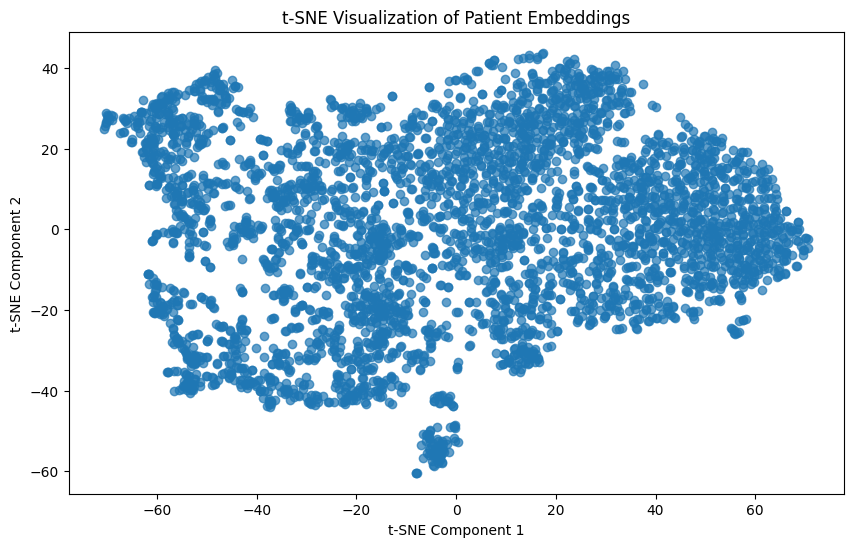

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load stored patient embeddings (if not already in memory)
# patient_embeddings_array = np.load("patient_embeddings.npy")  # Uncomment if loading from file

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(patient_embeddings_array)

# Scatter plot of embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# Visualize Batch Embeddings

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# For visualization, you can ignore the negative pairs and only focus on the anchor and positive embeddings
for batch in data_loader:
    xref_pos, xpos, _, _ = batch  # Unpack only the positive pairs (xref_pos, xpos)
    xref_pos = xref_pos.float().to(device)
    xpos = xpos.float().to(device)

    # Get embeddings from the model (only for anchor and positive pairs)
    emb = model(torch.cat([xref_pos, xpos], dim=0))  # Concatenate the anchor and positive pair

    # Now you can perform visualization on 'emb', which will contain the embeddings for the positive pairs
    # Optionally, you can apply dimensionality reduction (e.g., t-SNE) and visualize these embeddings
    embeddings_2d = tsne.fit_transform(emb.detach().cpu().numpy())
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    plt.title("t-SNE Visualization of Positive Pair Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


NameError: name 'tsne' is not defined

In [21]:
for batch in data_loader:
    xref_pos, xpos, xref_neg, xneg = batch  # Unpack all four
    xref_pos = xref_pos.float().to(device)
    xpos = xpos.float().to(device)
    xref_neg = xref_neg.float().to(device)
    xneg = xneg.float().to(device)

    emb = model(torch.cat([xref_pos, xpos, xref_neg, xneg], dim=0))  # Combine all for embeddings


RuntimeError: Tensors must have same number of dimensions: got 3 and 4

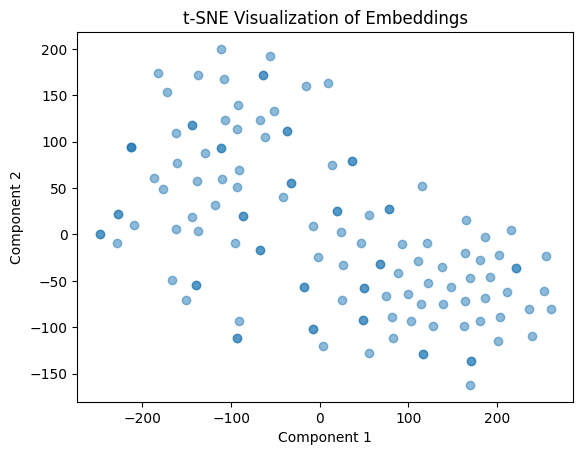

In [25]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
# Convert embeddings to NumPy array (detach the tensor first)
embeddings_2d = tsne.fit_transform(emb.detach().cpu().numpy())

# Plot embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


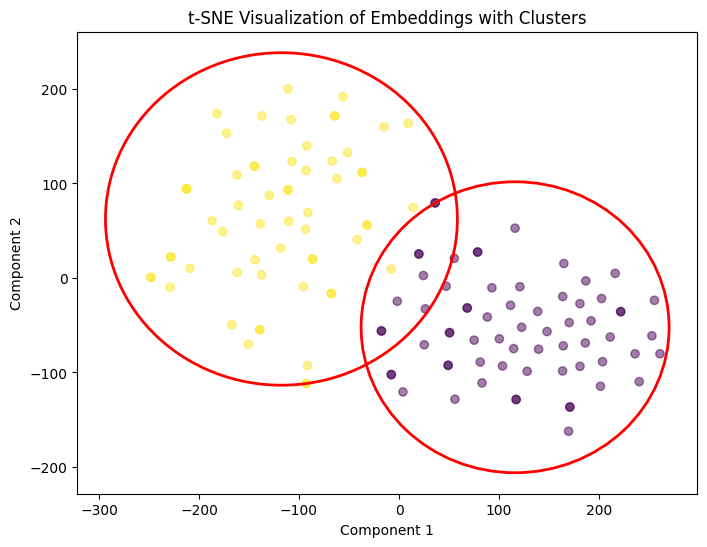

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.patches as patches

# Assuming you already have your embeddings, which is a tensor of shape [num_patients, embedding_dim]
# Convert embeddings to NumPy array (detach the tensor first)
embeddings_np = emb.detach().cpu().numpy()

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)


n_clusters = 2
# Cluster the embeddings using KMeans (for example, 3 clusters, you can change the number of clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings_2d)

# Plot embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, alpha=0.5, cmap='viridis')

# Draw circles around the clusters
for i in range(n_clusters):  # Loop through the number of clusters (adjust for your case)
    # Get points belonging to cluster i
    cluster_points = embeddings_2d[labels == i]
    
    # Calculate the centroid of the cluster
    centroid = np.mean(cluster_points, axis=0)
    
    # Calculate the radius (optional, but helps to make the circle around the cluster)
    max_distance = np.max(np.linalg.norm(cluster_points - centroid, axis=1))
    
    # Create a circle patch
    circle = patches.Circle(centroid, max_distance, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)

# Title and labels
plt.title("t-SNE Visualization of Embeddings with Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [23]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

def train_model(model, data_loader, optimizer, temperature=0.1, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0

        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as progress_bar:
            for batch in progress_bar:
                # Unpack the batch (xref_pos, xpos, xref_neg, xneg)
                xref_pos, xpos, _, xneg = batch  # Ignore xref_neg (not needed)

                # Move to device
                xref_pos = xref_pos.float().to(device)  # Anchor
                xpos = xpos.float().to(device)          # Positive sample
                xneg = xneg.float().to(device)          # Negative sample
                
                # Get embeddings from the model
                anchor_embedding = model(xref_pos)  # (batch_size, embedding_dim)
                positive_embedding = model(xpos)    # (batch_size, embedding_dim)
                negative_embedding = model(xneg)    # (batch_size, embedding_dim)

                # Compute InfoNCE loss
                loss = info_nce_loss(anchor_embedding, positive_embedding, negative_embedding, temperature)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())  # Update progress bar
                
        # Print average loss for the epoch
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, data_loader, optimizer)


Epoch 1/10:   0%|          | 0/375 [00:00<?, ?it/s]


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [ ]:
print(df_a.dtypes)      #returns all the types in the dataframe..

In [39]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

def train_model(model, data_loader, optimizer, temperature=0.1, num_epochs=10):
    model.train()
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        
        for batch in data_loader:
            # Unpack the batch (assuming it's in the format: (xref, xpos, xneg))
            xref_pos, xpos, xref_neg, xneg = batch  # (xref, xpos are from the same patient, xneg from a different patient)
            
            # Convert to torch tensors and move to device
            xref_pos = xref_pos.clone().detach().float().to(device)
            xpos = xpos.clone().detach().float().to(device)
            xref_neg = xref_neg.clone().detach().float().to(device)
            xneg = xneg.clone().detach().float().to(device)

            
            # Get embeddings for xref, xpos, xneg using the model
            xref_pos_embedding = model(xref_pos)  # Shape: [32, embedding_dim]
            xpos_embedding = model(xpos)  # Shape: [32, embedding_dim]
            xref_neg_embedding = model(xref_neg)  # Shape: [32, embedding_dim]
            xneg_embedding = model(xneg)  # Shape: [32, embedding_dim]
            
            # Compute InfoNCE loss
            # Positive similarity (xref_pos vs xpos)
            positive_similarity = F.cosine_similarity(xref_pos_embedding, xpos_embedding, dim=-1)  # Shape: [32]
            
            #print(f"positive_similarity shape: {positive_similarity.shape}")  # Check the shape
            
            # Negative similarity (xref_pos vs xref_neg, xpos vs xneg)
            negative_similarity_xref = torch.matmul(xref_pos_embedding, xref_neg_embedding.T)  # Shape: [32, 32]
            negative_similarity_xpos = torch.matmul(xpos_embedding, xneg_embedding.T)  # Shape: [32, 32]
            
            #print(f"negative_similarity_xref shape: {negative_similarity_xref.shape}")  # Check shape
            #print(f"negative_similarity_xpos shape: {negative_similarity_xpos.shape}")  # Check shape
            
            # Apply temperature scaling
            positive_similarity /= temperature
            negative_similarity_xref /= temperature
            negative_similarity_xpos /= temperature
            
            # Now we want to stack the positive similarity and the negative similarities
            # Expand positive similarity to match the shape of negative similarities
            positive_similarity_expanded = positive_similarity.unsqueeze(1)  # Shape: [32, 1]
            #print(f"positive_similarity_expanded shape: {positive_similarity_expanded.shape}")  # Check the shape
            
            # Concatenate positive similarity and negative similarities
            logits = torch.cat([positive_similarity_expanded, negative_similarity_xref, negative_similarity_xpos], dim=1)  # Shape: [32, 65]
            
            #print(f"logits shape: {logits.shape}")  # Check the final shape
            
            # Labels: the first column is the positive sample, others are negative samples
            labels = torch.zeros(logits.size(0), dtype=torch.long).to(logits.device)
            
            # Cross-entropy loss based on the logits
            loss = F.cross_entropy(logits, labels)
            
            # Backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            #print("loss: ", running_loss)
        
        # Print the average loss for the epoch
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming `data_loader` is a DataLoader that provides batches of (xref, xpos, xneg)
train_model(model, data_loader, optimizer)

 10%|█         | 1/10 [00:05<00:52,  5.85s/it]

Epoch 1/10, Loss: 0.3429


 20%|██        | 2/10 [00:13<00:56,  7.08s/it]

Epoch 2/10, Loss: 0.0310


 30%|███       | 3/10 [00:21<00:51,  7.42s/it]

Epoch 3/10, Loss: 0.0159


 40%|████      | 4/10 [00:29<00:45,  7.66s/it]

Epoch 4/10, Loss: 0.0112


 50%|█████     | 5/10 [00:37<00:38,  7.79s/it]

Epoch 5/10, Loss: 0.0087


 60%|██████    | 6/10 [00:46<00:31,  8.00s/it]

Epoch 6/10, Loss: 0.0075


 70%|███████   | 7/10 [00:52<00:22,  7.39s/it]

Epoch 7/10, Loss: 0.0066


 80%|████████  | 8/10 [00:56<00:12,  6.30s/it]

Epoch 8/10, Loss: 0.0057


 90%|█████████ | 9/10 [01:00<00:05,  5.58s/it]

Epoch 9/10, Loss: 0.0051


100%|██████████| 10/10 [01:06<00:00,  6.62s/it]

Epoch 10/10, Loss: 0.0047


In [ ]:
import numpy as np
import random

def augment_time_series(time_series, augmentation_types=['shift', 'jitter', 'scale'], shift_max=5, jitter_strength=0.01, scale_range=(0.8, 1.2)):
    """
    Augment a time-series sequence by applying random augmentations.
    
    Args:
    - time_series: The original time-series sequence to augment (numpy array).
    - augmentation_types: List of augmentation types to apply. Options: 'shift', 'jitter', 'scale', 'flip'.
    - shift_max: The maximum shift value for time-shifting.
    - jitter_strength: The strength of the jitter noise to add.
    - scale_range: The range for scaling values in the time series.
    
    Returns:
    - augmented_time_series: The augmented time-series sequence.
    """
    augmented_time_series = time_series.copy()
    
    # Apply Time Shifting
    if 'shift' in augmentation_types:
        shift_value = random.randint(-shift_max, shift_max)
        augmented_time_series = np.roll(augmented_time_series, shift_value)
    
    # Apply Jittering (Add small random noise)
    if 'jitter' in augmentation_types:
        noise = np.random.normal(loc=0.0, scale=jitter_strength, size=augmented_time_series.shape)
        augmented_time_series += noise
    
    # Apply Scaling
    if 'scale' in augmentation_types:
        scale_factor = random.uniform(*scale_range)
        augmented_time_series *= scale_factor

     
    # Apply Flipping (reverse the sequence)
    if 'flip' in augmentation_types:
        augmented_time_series = augmented_time_series[::-1]
    
    return augmented_time_series

# Example Usage:
# Create a random time-series sequence of length 48 (e.g., 48 hours of data)
time_series = np.random.rand(48, 3)

# Apply augmentation
augmented_time_series = augment_time_series(time_series, augmentation_types=['shift', 'jitter', 'scale'])

print("Original Time Series:", time_series)
print("Augmented Time Series:", augmented_time_series)
import numpy as np
import random

def create_positive_negative_pairs(df_a, time_series_vars, seq_length=48):
    """
    Create positive and negative pairs from time-series data for contrastive learning.
    
    Args:
    - df_a: The dataframe containing the time-series data for all patients.
    - time_series_vars: List of time-series variable names (37 time-series variables).
    - seq_length: Length of the time-series sequence (e.g., 48 hours).
    
    Returns:
    - positive_pairs: List of tuples (xref, xpos) for positive pairs.
    - negative_pairs: List of tuples (xref, xneg) for negative pairs.
    """
    positive_pairs = []
    negative_pairs = []
    
    # Group the data by PatientID
    grouped = df_a.groupby('PatientID')

    # Iterate over each patient
    for patient_id, patient_data in grouped:
        # Extract the time-series data for the current patient
        time_series_data = patient_data[time_series_vars].values
        
        # Loop over the time-series data and create pairs
        for i in range(seq_length - 1):  # Iterate over time windows for positive pairs
            # Positive pair: pick two consecutive sub-sequences from the same patient
            xpos = time_series_data[i]  # First time window (positive)
            xref = time_series_data[i + 1]  # Second time window (positive)
            positive_pairs.append((xref, xpos))
            
            # Negative pair: randomly pick a time-series sub-sequence from a different patient
            other_patient_id = random.choice([pid for pid in df_a['PatientID'].unique() if pid != patient_id])  # Randomly pick a different patient ID
            other_patient_data = df_a[df_a['PatientID'] == other_patient_id][time_series_vars].values
            
            # Pick a random time-window from the other patient
            random_time_window = random.choice(other_patient_data)
            
            # Add the negative sample (xref from current patient, xneg from different patient)
            negative_pairs.append((xref, random_time_window))

    # Ensure that the number of positive and negative pairs are the same
    assert len(positive_pairs) == len(negative_pairs), "Mismatch in the number of positive and negative pairs"
    
    return positive_pairs, negative_pairs

# Example usage:
# positive_pairs, negative_pairs = create_positive_negative_pairs(df, time_series_vars)

# Print a sample positive and negative pair
#print(f"Sample Positive Pair: {positive_pairs[0]}")
#print(f"Sample Negative Pair: {negative_pairs[0]}")

